In [27]:
import xml.etree.ElementTree as ET
import pandas as pd

def parse_xml(xml_file):
    columns = ["type", "sourceName", "unit", "creationDate", "startDate", "endDate", "value"]
    records = []
    
    context = ET.iterparse(xml_file, events=("start", "end"))
    _, root = next(context)

    for event, elem in context:
        if event == "end" and elem.tag == "Record":
            record = [elem.get(column) for column in columns]
            records.append(record)
            root.clear()

    df = pd.DataFrame(records, columns=columns)
    return df

temp_df = parse_xml(r'raw_health_export.xml').copy()

In [28]:
# temp = temp_df['type'].unique()

# temp

array(['HKQuantityTypeIdentifierDietaryWater',
       'HKQuantityTypeIdentifierBodyMassIndex',
       'HKQuantityTypeIdentifierHeight',
       'HKQuantityTypeIdentifierBodyMass',
       'HKQuantityTypeIdentifierHeartRate',
       'HKQuantityTypeIdentifierOxygenSaturation',
       'HKQuantityTypeIdentifierRespiratoryRate',
       'HKQuantityTypeIdentifierStepCount',
       'HKQuantityTypeIdentifierDistanceWalkingRunning',
       'HKQuantityTypeIdentifierBasalEnergyBurned',
       'HKQuantityTypeIdentifierActiveEnergyBurned',
       'HKQuantityTypeIdentifierFlightsClimbed',
       'HKQuantityTypeIdentifierDietaryEnergyConsumed',
       'HKQuantityTypeIdentifierNumberOfTimesFallen',
       'HKQuantityTypeIdentifierAppleExerciseTime',
       'HKQuantityTypeIdentifierDistanceCycling',
       'HKQuantityTypeIdentifierDistanceSwimming',
       'HKQuantityTypeIdentifierSwimmingStrokeCount',
       'HKQuantityTypeIdentifierRestingHeartRate',
       'HKQuantityTypeIdentifierVO2Max',
       'HKQu

In [29]:
#function to parse original df and seperate each group into own cv file

def split_df_by_type_and_save(df, output_dir):
    # Get the unique values in the 'type' column
    df['type'] = df['type'].str.extract(r'TypeIdentifier(.*)')
    unique_types = df['type'].unique()
    
    # Create a separate CSV file for each unique type
    for t in unique_types:
        # Filter the DataFrame by the current type
        filtered_df = df[df['type'] == t]
        
        # Save the filtered DataFrame to a new CSV file
        output_file = f"{output_dir}/{t}.csv"
        filtered_df.to_csv(output_file, index=False)
        
output_dir = r'C:\Users\paddy\Documents\Kaggle_competition'
split_df_by_type_and_save(temp_df, output_dir)

# heartrate, stepcount are the two files that i may supplement into a model (still dont know what model)

STARTING HERE


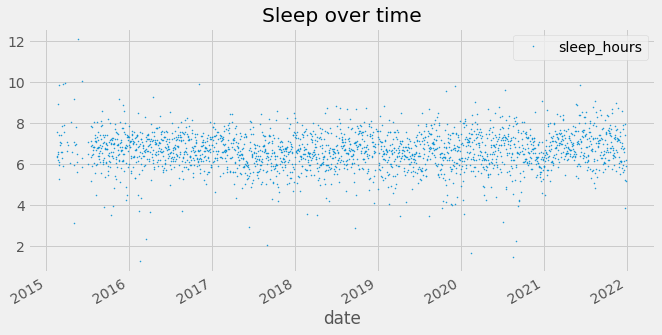

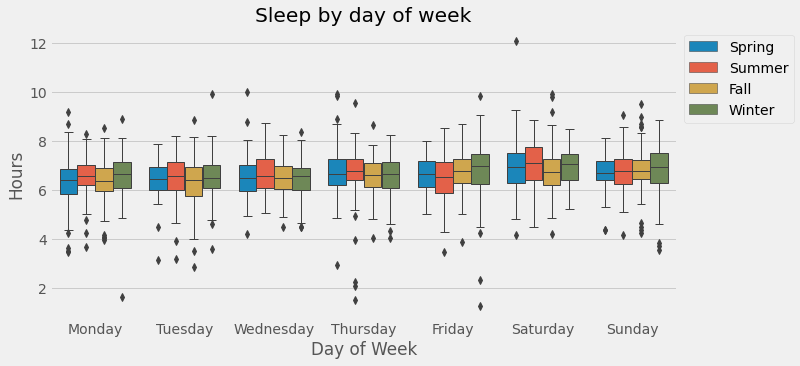

In [66]:
#Measuring the accuracy of the model

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from pandas.api.types import CategoricalDtype
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings

warnings.filterwarnings('ignore')
plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

#taking in data and doing basic visuals to see our starting point
base_df = pd.read_csv(r'C:\Users\paddy\Documents\Kaggle_competition\downloaded_data\train.csv', index_col=[0], parse_dates=[0])
pd.to_datetime(base_df.index)
#getting rid of the possible double entries
base_df["sleep_hours"].iloc[833:1090] /= 2 

color_pal = sns.color_palette()
base_df.plot(style='.', figsize=(10,5), ms=1, color=color_pal[0],title='Sleep over time', )

plt.show()

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['hour','dayofweek','quarter','month','year',
        'dayofyear','dayofmonth','weekofyear','weekday',
        'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(base_df, label='sleep_hours')
features_and_target = pd.concat([X, y], axis=1)

fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='sleep_hours',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Sleep by day of week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Hours')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

Train / Test Split

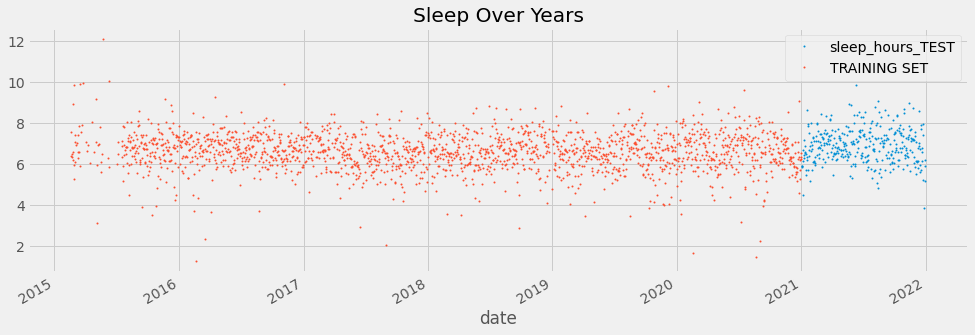

In [67]:
split_date = '1-JAN-2021'
data_train = base_df.loc[base_df.index <= split_date].copy().add_suffix('_TRAIN')
data_test = base_df.loc[base_df.index > split_date].copy().add_suffix('_TEST')

# Plot train and test so you can see where we have split
data_test \
    .rename(columns={'BASE_DF_TEST': 'TEST SET'}) \
    .join(data_train.rename(columns={'sleep_hours_TRAIN': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15, 5), title='Sleep Over Years', style='.', ms=2)
plt.show()


Modeling

06:50:43 - cmdstanpy - INFO - Chain [1] start processing
06:50:43 - cmdstanpy - INFO - Chain [1] done processing


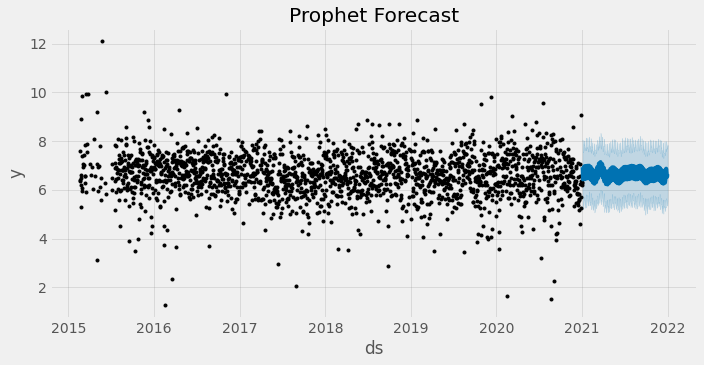

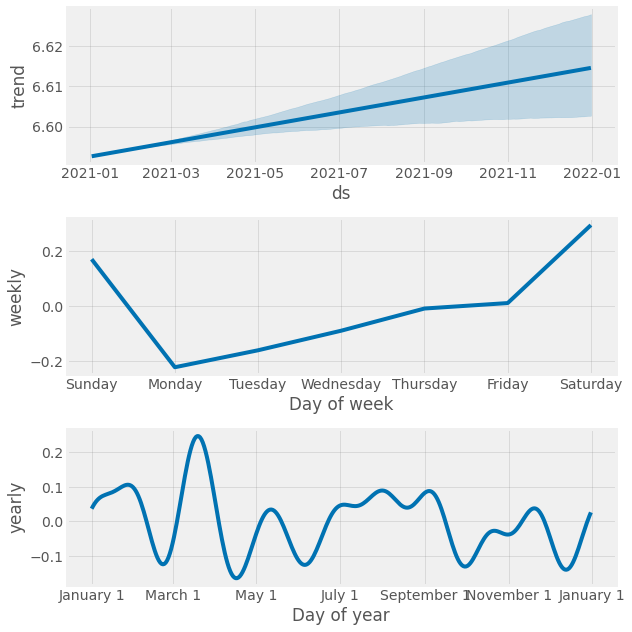

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-02,6.592627,5.878693,8.065393,6.592627,6.592627,0.339688,0.339688,0.339688,0.295375,0.295375,0.295375,0.044313,0.044313,0.044313,0.0,0.0,0.0,6.932315
1,2021-01-03,6.592687,5.722129,7.981277,6.592687,6.592687,0.222181,0.222181,0.222181,0.171299,0.171299,0.171299,0.050881,0.050881,0.050881,0.0,0.0,0.0,6.814868
2,2021-01-04,6.592748,5.194061,7.596675,6.592748,6.592748,-0.165130,-0.165130,-0.165130,-0.221678,-0.221678,-0.221678,0.056548,0.056548,0.056548,0.0,0.0,0.0,6.427618
3,2021-01-05,6.592808,5.349717,7.542319,6.592808,6.592808,-0.098610,-0.098610,-0.098610,-0.159970,-0.159970,-0.159970,0.061360,0.061360,0.061360,0.0,0.0,0.0,6.494198
4,2021-01-06,6.592868,5.379246,7.605981,6.592868,6.592868,-0.023312,-0.023312,-0.023312,-0.088696,-0.088696,-0.088696,0.065384,0.065384,0.065384,0.0,0.0,0.0,6.569556


In [68]:
from prophet import Prophet

# Format data for prophet model using ds and y
sleep_train_prophet = data_train.reset_index() \
    .rename(columns={'date':'ds',
                     'sleep_hours_TRAIN':'y'})


model = Prophet()
model.fit(sleep_train_prophet)



# Predict on test set with model
sleep_test_prophet = data_test.reset_index() \
    .rename(columns={'date':'ds',
                     'sleep_hours_TRAIN':'y'})

sleep_test_fcst = model.predict(sleep_test_prophet)

#model graph
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(sleep_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

#model components
fig = model.plot_components(sleep_test_fcst)
plt.show()


sleep_test_fcst.head()

Forecast with actuals

0.8815044937204715
0.6901258555357522


9.856889804424295

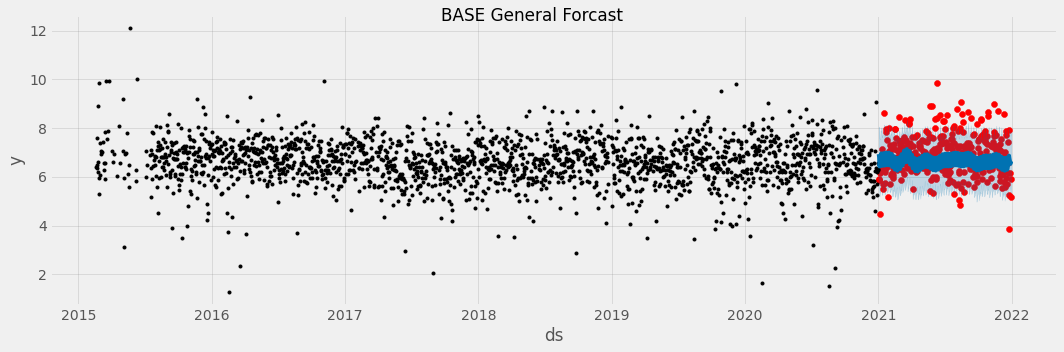

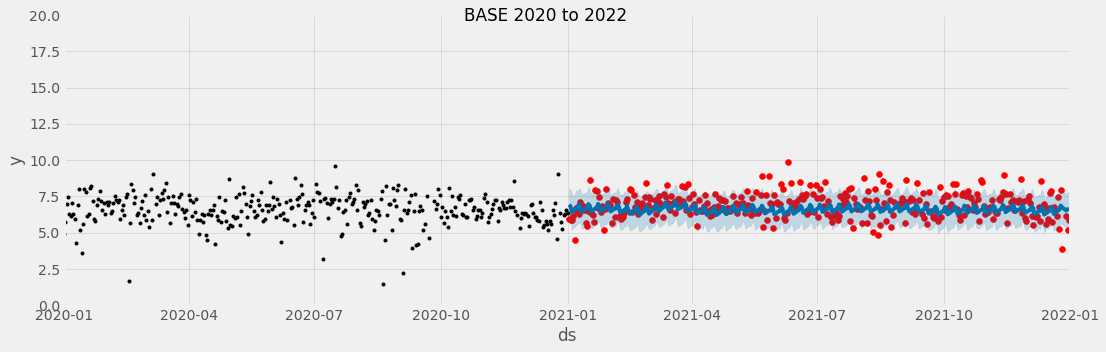

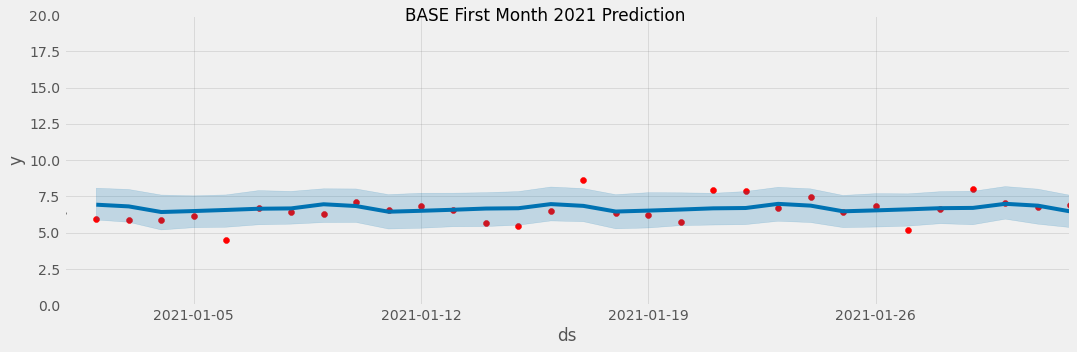

In [69]:
import datetime
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(data_test.index, data_test['sleep_hours_TEST'], color='r')
fig = model.plot(sleep_test_fcst, ax=ax)
plot = plt.suptitle('BASE General Forcast')

#smaller view
fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(data_test.index, data_test['sleep_hours_TEST'], color='r')
fig = model.plot(sleep_test_fcst, ax=ax)
ax.set_xbound(lower=datetime.datetime.strptime('2020-01-01', '%Y-%m-%d'),
              upper=datetime.datetime.strptime('2022-01-01', '%Y-%m-%d'))
ax.set_ylim(0, 20)
plot = plt.suptitle('BASE 2020 to 2022')

#even smaller view
fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(data_test.index, data_test['sleep_hours_TEST'], color='r')
fig = model.plot(sleep_test_fcst, ax=ax)
ax.set_xbound(lower=datetime.datetime.strptime('2021-01-01', '%Y-%m-%d'),
              upper=datetime.datetime.strptime('2021-02-01', '%Y-%m-%d'))
ax.set_ylim(0, 20)
plot = plt.suptitle('BASE First Month 2021 Prediction')

##______________________________________________

#first pass : 0.9207128038030028
##second pass: 0.9492456727597836 10/1/2021 (bad),  0.8802633615299584 (best)
print(np.sqrt(mean_squared_error(y_true=data_test['sleep_hours_TEST'],
                   y_pred=sleep_test_fcst['yhat'])))
#-----

#first pass : 0.7169545996944965 1/1/21 (better)
##second pass: 0.7444629823577802 10/1/2021 (bad),
print(mean_absolute_error(y_true=data_test['sleep_hours_TEST'],
                   y_pred=sleep_test_fcst['yhat']))
#-----

#first pass: 10.417538555861332 1/1/2021 (better), 
#second pass: 11.897855990178247 10/1/2021 (bad), 
def mean_absolute_percentage_error(y_true, y_pred):

    y_true, y_pred = np.array(y_true), np.array(y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=data_test['sleep_hours_TEST'],
                   y_pred=sleep_test_fcst['yhat'])

#-----

SEEING IF HOLIDAYS DO ANYTHING

05:35:56 - cmdstanpy - INFO - Chain [1] start processing
05:35:56 - cmdstanpy - INFO - Chain [1] done processing


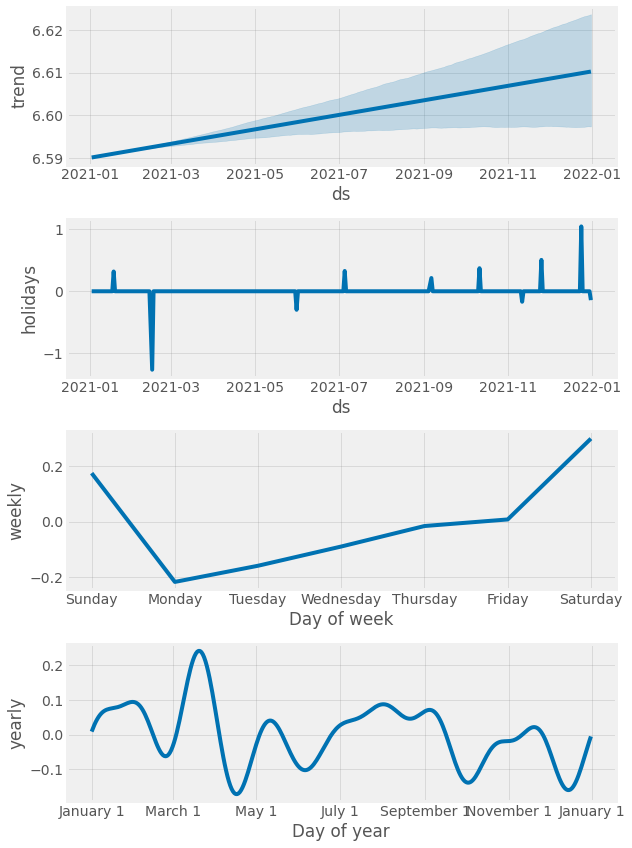

0.8961983967258045
0.6944706647277392


9.919335728254064

In [6]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()


holidays = cal.holidays(start=base_df.index.min(),
                        end=base_df.index.max(),
                        return_name=True)
holiday_df = pd.DataFrame(data=holidays,
                          columns=['holiday'])
holiday_df = holiday_df.reset_index().rename(columns={'index':'ds'})


model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(sleep_train_prophet)

sleep_test_fcst_with_hols = \
    model_with_holidays.predict(df=sleep_test_prophet)

fig = model_with_holidays.plot_components(
    sleep_test_fcst_with_hols)
plt.show()

print(np.sqrt(mean_squared_error(y_true=data_test['sleep_hours_TEST'],
                   y_pred=sleep_test_fcst_with_hols['yhat'])))

print(mean_absolute_error(y_true=data_test['sleep_hours_TEST'],
                   y_pred=sleep_test_fcst_with_hols['yhat']))

def mean_absolute_percentage_error(y_true, y_pred):

    y_true, y_pred = np.array(y_true), np.array(y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=data_test['sleep_hours_TEST'],
                   y_pred=sleep_test_fcst_with_hols['yhat'])


AVG HEART RATE

04:32:51 - cmdstanpy - INFO - Chain [1] start processing
04:32:51 - cmdstanpy - INFO - Chain [1] done processing


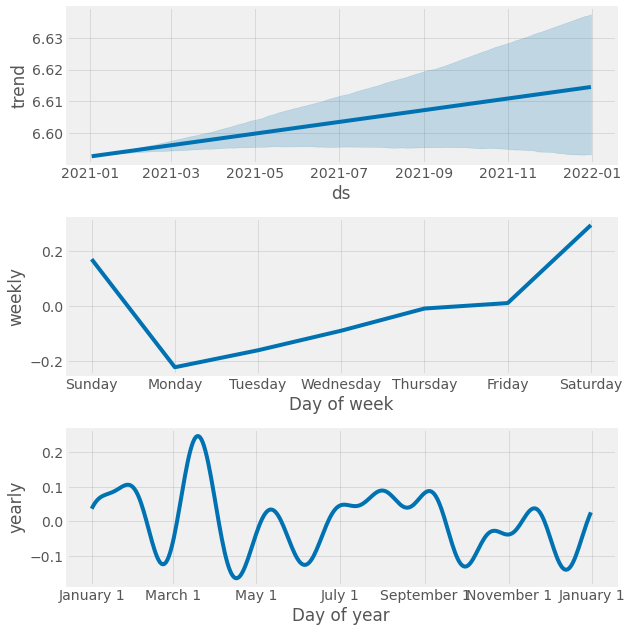

0.8815044937204715
0.6901258555357522


9.856889804424295

In [15]:
#not fucntioninig / need to know future hr which isnt really plausible for a real model ...on hold

heart_rate_df = pd.read_csv(r'HeartRate.csv', index_col=[0], parse_dates=[0])


# convert the start and end date columns to datetime format
heart_rate_df['endDate'] = pd.to_datetime(heart_rate_df['endDate'])

# extract the date only from the endDate column
heart_rate_df['endDate'] = heart_rate_df['endDate'].dt.date

# group the data by date and calculate the average value
avg_heart_rate = heart_rate_df.groupby('endDate')['value'].mean().reset_index()\
                    .rename(columns={'endDate':'ds', 'value':'y'})

model_with_avghr = Prophet(interval_width=0.95 ,daily_seasonality=False)

model_with_avghr.fit(sleep_train_prophet)

sleep_test_fcst_with_avghr = \
    model_with_avghr.predict(df=sleep_test_prophet)

fig = model_with_avghr.plot_components(
    sleep_test_fcst_with_avghr)
plt.show()

print(np.sqrt(mean_squared_error(y_true=data_test['sleep_hours_TEST'],
                   y_pred=sleep_test_fcst_with_avghr['yhat'])))

print(mean_absolute_error(y_true=data_test['sleep_hours_TEST'],
                   y_pred=sleep_test_fcst_with_avghr['yhat']))

def mean_absolute_percentage_error(y_true, y_pred):

    y_true, y_pred = np.array(y_true), np.array(y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=data_test['sleep_hours_TEST'],
                   y_pred=sleep_test_fcst_with_avghr['yhat'])


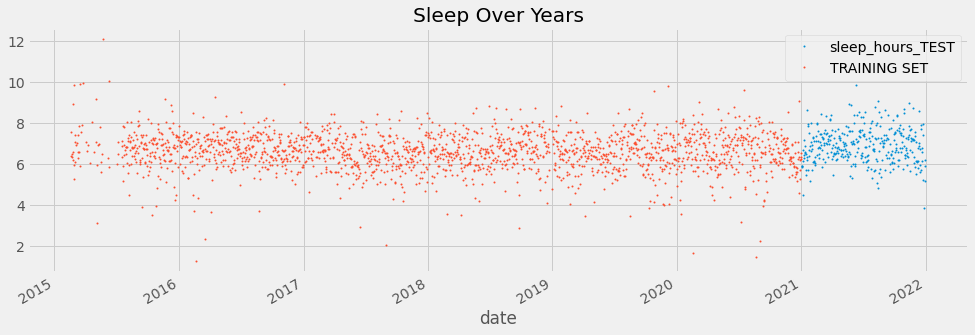

06:50:58 - cmdstanpy - INFO - Chain [1] start processing
06:50:58 - cmdstanpy - INFO - Chain [1] done processing


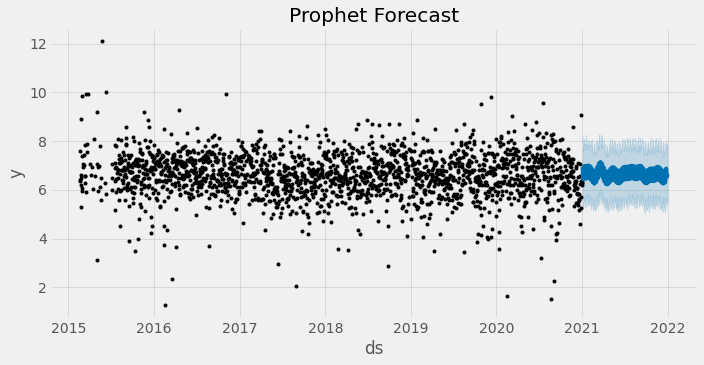

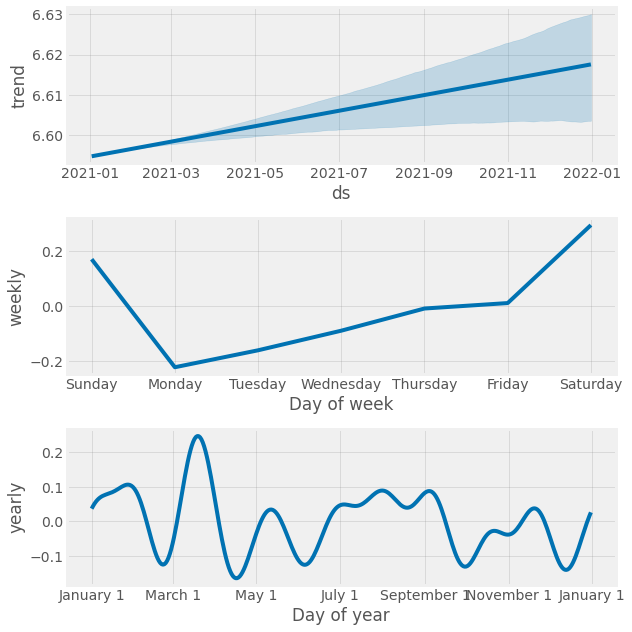

0.8806011096202592
0.6894465532286365


9.850449572080617

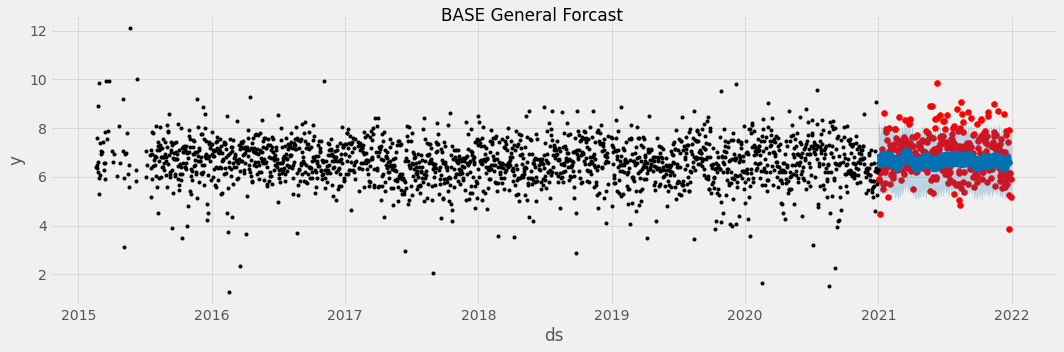

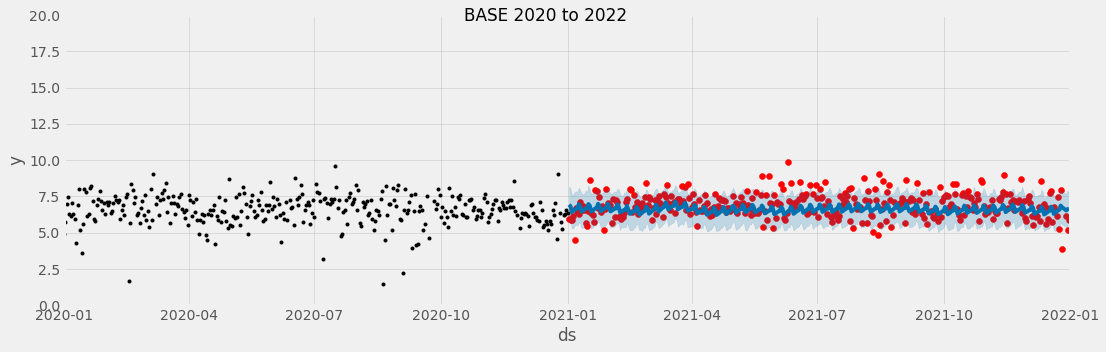

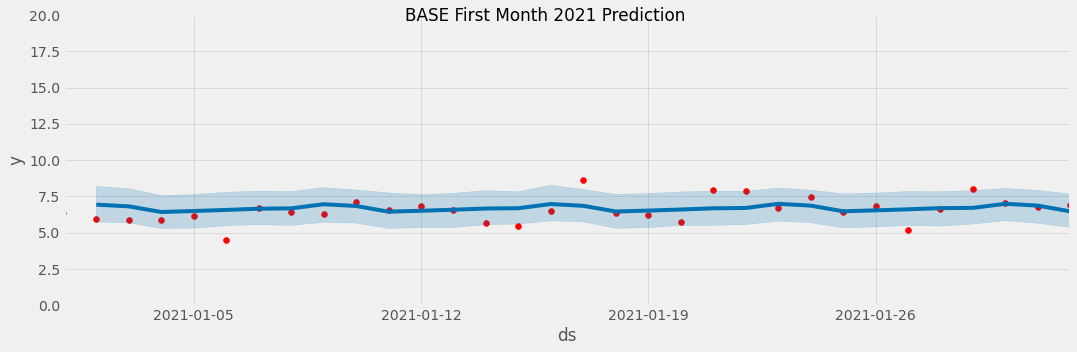

In [70]:

from prophet import Prophet

split_date_2 = '1-JAN-2021'
data_train_2 = base_df.loc[base_df.index <= split_date_2].copy().add_suffix('_TRAIN')
data_test_2 = base_df.loc[base_df.index > split_date_2].copy().add_suffix('_TEST')

# Plot train and test so you can see where we have split
data_test_2 \
    .rename(columns={'BASE_DF_TEST': 'TEST SET'}) \
    .join(data_train_2.rename(columns={'sleep_hours_TRAIN': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15, 5), title='Sleep Over Years', style='.', ms=2)
plt.show()

# Format data for prophet model using ds and y
sleep_train_prophet_2 = data_train_2.reset_index() \
    .rename(columns={'date':'ds',
                     'sleep_hours_TRAIN':'y'})


model = Prophet(changepoint_prior_scale=0.0551, seasonality_prior_scale=10, seasonality_mode='additive', changepoint_range=.80)
model.fit(sleep_train_prophet_2)



# Predict on test set with model
sleep_test_prophet_2 = data_test_2.reset_index() \
    .rename(columns={'date':'ds',
                     'sleep_hours_TRAIN':'y'})

sleep_test_fcst_2 = model.predict(sleep_test_prophet_2)

#model graph
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(sleep_test_fcst_2, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

#model components
fig = model.plot_components(sleep_test_fcst_2)
plt.show()


sleep_test_fcst_2.head()

import datetime
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(data_test_2.index, data_test_2['sleep_hours_TEST'], color='r')
fig = model.plot(sleep_test_fcst_2, ax=ax)
plot = plt.suptitle('BASE General Forcast')

#smaller view
fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(data_test_2.index, data_test_2['sleep_hours_TEST'], color='r')
fig = model.plot(sleep_test_fcst_2, ax=ax)
ax.set_xbound(lower=datetime.datetime.strptime('2020-01-01', '%Y-%m-%d'),
              upper=datetime.datetime.strptime('2022-01-01', '%Y-%m-%d'))
ax.set_ylim(0, 20)
plot = plt.suptitle('BASE 2020 to 2022')

#even smaller view
fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(data_test_2.index, data_test_2['sleep_hours_TEST'], color='r')
fig = model.plot(sleep_test_fcst_2, ax=ax)
ax.set_xbound(lower=datetime.datetime.strptime('2021-01-01', '%Y-%m-%d'),
              upper=datetime.datetime.strptime('2021-02-01', '%Y-%m-%d'))
ax.set_ylim(0, 20)
plot = plt.suptitle('BASE First Month 2021 Prediction')

##______________________________________________

#first pass : 0.9207128038030028
##second pass: 0.9492456727597836 10/1/2021 (bad),  0.8802633615299584 (best)
print(np.sqrt(mean_squared_error(y_true=data_test_2['sleep_hours_TEST'],
                   y_pred=sleep_test_fcst_2['yhat'])))
#-----

#first pass : 0.7169545996944965 1/1/21 (better)
##second pass: 0.7444629823577802 10/1/2021 (bad),
print(mean_absolute_error(y_true=data_test_2['sleep_hours_TEST'],
                   y_pred=sleep_test_fcst_2['yhat']))
#-----

#first pass: 10.417538555861332 1/1/2021 (better), 
#second pass: 11.897855990178247 10/1/2021 (bad), 
def mean_absolute_percentage_error(y_true, y_pred):

    y_true, y_pred = np.array(y_true), np.array(y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=data_test_2['sleep_hours_TEST'],
                   y_pred=sleep_test_fcst_2['yhat'])


  0%|          | 0/4 [00:00<?, ?it/s]

06:53:54 - cmdstanpy - INFO - Chain [1] start processing
06:53:54 - cmdstanpy - INFO - Chain [1] done processing
06:53:55 - cmdstanpy - INFO - Chain [1] start processing
06:53:55 - cmdstanpy - INFO - Chain [1] done processing
06:53:55 - cmdstanpy - INFO - Chain [1] start processing
06:53:55 - cmdstanpy - INFO - Chain [1] done processing
06:53:55 - cmdstanpy - INFO - Chain [1] start processing
06:53:55 - cmdstanpy - INFO - Chain [1] done processing


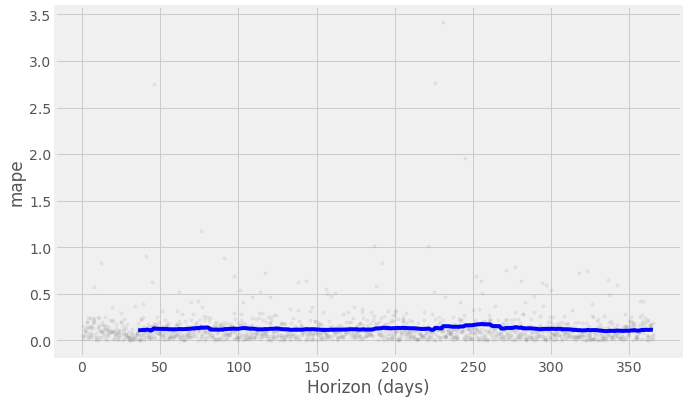

In [74]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric



sleep_train_prophet_2_cv = cross_validation(model, initial='1095 days', period='180 days', horizon='365 days')
sleep_train_prophet_2_cv.head()
df_p = performance_metrics(sleep_train_prophet_2_cv)
fig = plot_cross_validation_metric(sleep_train_prophet_2_cv, metric='mape')

[08:15:01] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:6.21224	validation_1-rmse:6.49769
[100]	validation_0-rmse:2.42940	validation_1-rmse:2.68859
[200]	validation_0-rmse:1.22289	validation_1-rmse:1.41854
[300]	validation_0-rmse:0.94260	validation_1-rmse:1.04427
[400]	validation_0-rmse:0.89264	validation_1-rmse:0.93746
[500]	validation_0-rmse:0.88062	validation_1-rmse:0.90272
[600]	validation_0-rmse:0.87440	validation_1-rmse:0.89119
[700]	validation_0-rmse:0.86879	validation_1-rmse:0.88674
[800]	validation_0-rmse:0.86281	validation_1-rmse:0.88392
[900]	validation_0-rmse:0.85811	validation_1-rmse:0.88310
[1000]	validation_0-rmse:0.85276	validation_1-rmse:0.88180
[1097]	validation_0-rmse:0.84824	validation_1-rmse:0.88220


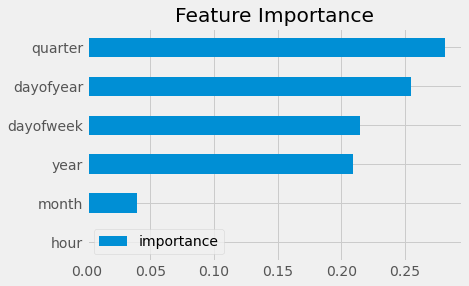

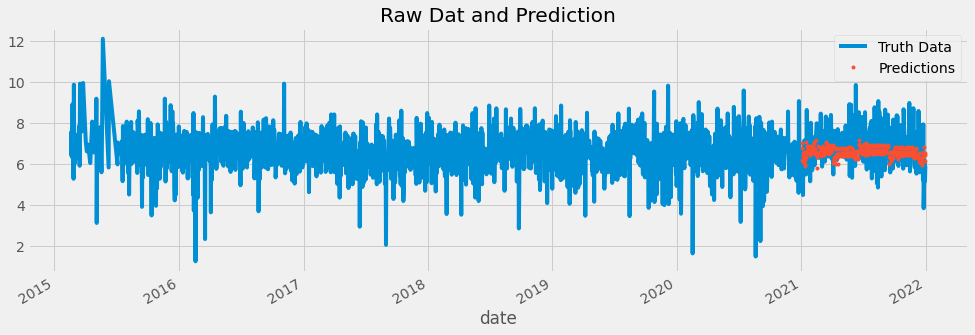

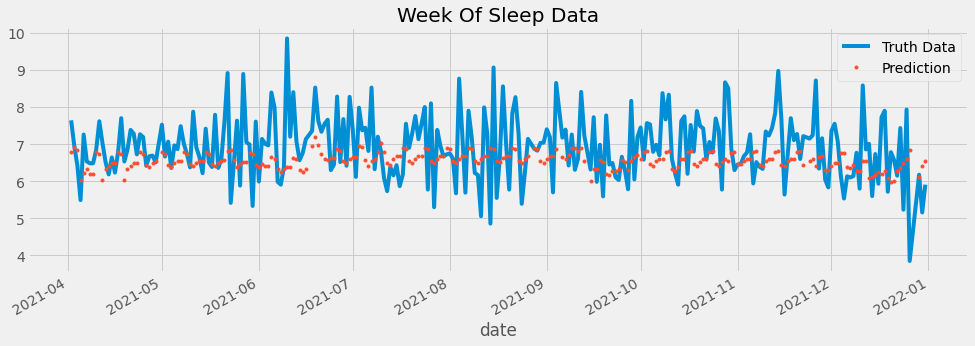

RMSE Score on Test set: 0.88153856


date
2021-06-10    3.453380
2021-12-26    2.986889
2021-05-27    2.360865
2021-11-26    2.307703
2021-08-15    2.205951
2021-02-15    2.186737
2021-11-14    2.162623
2021-08-04    2.156183
2021-05-22    2.102161
2021-10-28    2.071402
Name: error, dtype: float64

In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

pd.to_datetime(base_df.index)

def create_features(df, label=None):
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    df['sleep_hours'] = df['sleep_hours']
    X = df[['hour','dayofweek','quarter','month','year',
        'dayofyear','dayofmonth','weekofyear','weekday',
        'season', 'sleep_hours']]
    if label:
        y = df[label]
        return X, y
    return X

base_df_2 = create_features(base_df)

split_date = '1-JAN-2021'
train = base_df_2.loc[base_df_2.index <= split_date].copy()
test = base_df_2.loc[base_df_2.index > split_date].copy()

train = create_features(train)
test = create_features(test)




FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'sleep_hours'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

reg = xgb.XGBRegressor(base_score=0.4, booster='gbtree',    
                       n_estimators=25000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()


test['prediction'] = reg.predict(X_test)
df = base_df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['sleep_hours']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

ax = df.loc[(df.index > '04-01-2021') & (df.index < '01-01-2022')]['sleep_hours'] \
    .plot(figsize=(15, 5), title='Week Of Sleep Data') 

df.loc[(df.index > '04-01-2021') & (df.index < '01-01-2022')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

score = np.sqrt(mean_squared_error(test['sleep_hours'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.8f}')



test['error'] = np.abs(test[TARGET] - test['prediction'])
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)